- 필요 모듈

In [18]:
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
import random
from sklearn.utils import resample

## 음악추천 알고리즘

### 1. 장르 분류 모델
- 캐글에서 수집한 음악 청취수 데이터에는 장르 정보가 포함되어 있지 않습니다. <br>따라서, 장르가 포함되어있는 30000 Spotify Songs data를 통해 음악의 특성을 기반으로 장르를 분류하는 모델을 개발하고자 합니다

####  데이터 전처리 및 탐색 

In [5]:
# 30000 spotify 데이터 불러오기

spotify_30000 = pd.read_csv('./data/thirty_thousand_spotify_songs.csv', sep=',')
spotify_30000.head(2)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.00000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.00421,0.3570,0.693,99.972,162600


In [6]:
# Null 값 제거

spotify_30000 = spotify_30000.dropna()

# playlist_genre 데이터를 숫자형 데이터로 변경

label_encoder = LabelEncoder()
spotify_30000['playlist_genre_num'] = label_encoder.fit_transform(spotify_30000['playlist_genre'])

```
숫자별 의미하는 장르
0: edm, 1: latin, 2: pop, 3: r&b, 4: rap, 5: rock
```

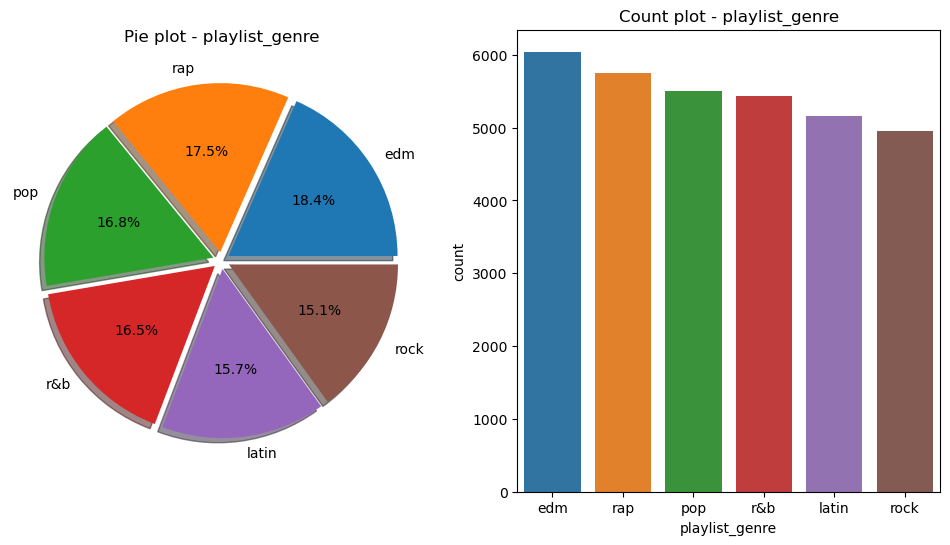

In [7]:
# 장르별 음악 데이터 분포 확인

f, ax = plt.subplots(1, 2, figsize=(12, 6))

# 장르 비율
spotify_30000['playlist_genre'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', shadow=True, explode=[0.05] * 6)
ax[0].set_title('Pie plot - playlist_genre')
ax[0].set_ylabel('')

# 장르 Count
genre_cnt = spotify_30000['playlist_genre'].value_counts()
sns.countplot(x='playlist_genre', data=spotify_30000, order=genre_cnt.index, ax=ax[1])
ax[1].set_title('Count plot - playlist_genre')

plt.show();

- 각 장르별 음악 데이터 분포를 시각화하여 분석한 결과, 각 장르의 데이터가 비슷한 비율로 분포되어 있는 것으로 확인되었습니다.

#### 30000 spotify 데이터와 Weather data의 일치하는 컬럼

- 'spotify_id' = 'track_id' → 음악 고유 ID

- 'artist' = 'track_artist' → 아티스트 고유 ID

- 'track_name' = 'track_name' → 앨범명


- 'danceability' = 'danceability' → 템포, 리듬 안정성, 비트 강도 및 전반적인 규칙성을 포함한 음악적 요소의 조합을 기반으로 <br> 트랙이 댄스에 얼마나 적합한지를 나타냅니다. 값이 0.0이면 춤을 추기에 가장 적합하지 않고 1.0이면 가장 춤을 추기에 적합합니다. 

- 'energy' = 'energy' → 0.0에서 1.0 사이의 척도이며 강도와 활동의 지각적 척도를 나타냅니다. <br> 일반적으로 에너지가 넘치는 트랙은 빠르고 시끄럽고 시끄럽게 느껴집니다. 예를 들어, 데스 메탈은 에너지가 높은 반면 바흐의 전주곡은 낮은 점수를 받았습니다. <br> 이 속성에 기여하는 지각적 특징에는 동적 범위, 인지된 음량, 음색, 시작 속도 및 일반 엔트로피가 포함됩니다.

- 'instrumentalness' = 'instrumentalness' → 트랙에 보컬이 포함되어 있지 않은지 여부를 예측합니다. <br> 이 문맥에서는 "우"와 "아" 소리가 악기 소리로 취급됩니다. 랩이나 음성 트랙은 분명히 "보컬"입니다. <br> 악기성 값이 1.0에 가까울수록 트랙에 보컬 콘텐츠가 포함되지 않을 가능성이 커집니다. <br> 0.5보다 큰 값은 악기 트랙을 나타내기 위한 것이지만 값이 1.0에 가까울수록 신뢰도가 높아집니다.

- 'key' = 'key' → 트랙의 예상 전체 키입니다. 정수는 표준 피치 클래스 표기법을 사용하여 피치에 매핑됩니다. <br>예를 들어 0 = C, 1 = C♯/D♭, 2 = D 등입니다. 키가 감지되지 않은 경우 값은 -1입니다.

- 'liveness' = 'liveness' → 녹화에서 청중의 존재를 감지합니다. 활성 값이 높을수록 트랙이 라이브로 수행될 확률이 높아집니다. <br>0.8보다 큰 값은 트랙이 라이브일 가능성이 높습니다.

- 'loudness' = 'loudness' → 데시벨(dB)로 표시되는 트랙의 전체 음량입니다. 음량 값은 전체 트랙의 평균을 구하며 트랙의 상대적 음량을 비교하는 데 유용합니다. <br>음량은 물리적 강도(진폭)의 주요 심리적 상관관계인 소리의 품질입니다. 일반적인 값 범위는 -60~0db입니다.

- 'speechiness' = 'speechiness' → 트랙에서 음성 단어의 존재를 감지합니다. 음성과 유사한 녹음(예: 토크쇼, 오디오북, 시)이 많을수록 <br>속성 값은 1.0에 가까워집니다. 0.66 이상의 값은 아마도 전적으로 음성으로 구성된 트랙을 나타냅니다. <br> 0.33에서 0.66 사이의 값은 랩 음악과 같은 경우를 포함하여 섹션 또는 레이어로 음악과 음성을 모두 포함할 수 있는 트랙을 나타냅니다. <br> 0.33 미만의 값은 음악 및 기타 음성과 유사한 트랙을 나타낼 가능성이 높습니다.

- 'acousticness' = 'acousticness' → 트랙이 음향인지 여부에 대한 0.0에서 1.0 사이의 신뢰도 측정값입니다. <br> 1.0은 트랙이 음향적이라는 높은 신뢰도를 나타냅니다.

- 'tempo' = 'tempo' → 분당 비트 수(BPM)로 표시되는 트랙의 전체 예상 템포입니다. <br> 음악 용어에서 템포는 주어진 곡의 속도 또는 속도이며 평균 비트 지속 시간에서 직접 파생됩니다.

- 'valence' = 'valence' → 트랙이 전달하는 음악적 긍정성을 설명하는 0.0에서 1.0 사이의 측정값입니다. <br> 원자가가 높은 트랙은 더 긍정적인 소리(예: 행복, 쾌활함, 행복감)를 내는 반면, 낮은 원자가의 트랙은 더 부정적인 소리(예: 슬픔, 우울, 분노)를 냅니다.

#### 장르 분류 모델에 필요한 컬럼
- 장르 분류 모델을 위한 컬럼을 선택한 기준은 30000 spotify 데이터와 Weather data의 일치하는 컬럼 중 음악적 특성과 장르를 선택합니다.
- [playlist_genre_num', 'danceability', 'energy', 'key', 'loudness', 'speechiness',  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [ ]:
# 장르 분류 모델에 필요한 컬럼만 데이터 프레임으로 정리

spotify_model = spotify_30000[['playlist_genre_num', 'danceability', 'energy', 'key', 'loudness', 'speechiness',
                        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# 컬럼 타입 실수형으로 맞춤

spotify_model = spotify_model.astype(float)
spotify_model.info()

# 피처, 라벨 분리

X = spotify_model.drop(['playlist_genre_num'], axis=1)
y = spotify_model['playlist_genre_num']


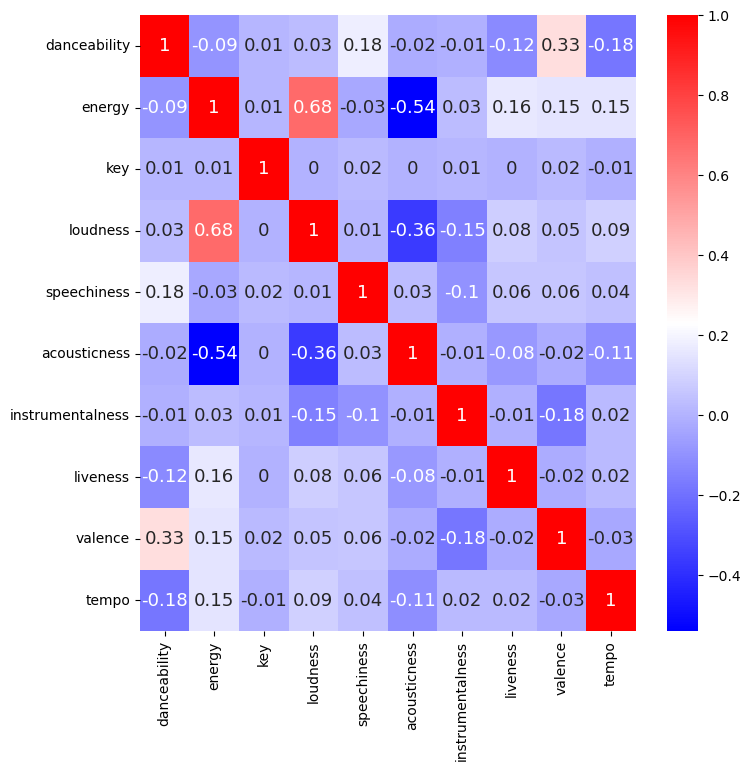

In [9]:
# 음악 특성별 상관관계 확인

correlation_matrix = X.corr().round(2)

plt.figure(figsize=(8, 8))
sns.heatmap(data=correlation_matrix, annot=True, cmap='bwr', annot_kws={'size': 13})
plt.rcParams['font.size'] = 10
plt.show();

#### 음악 특성별 상관관계 확인
- danceablility vs valence : 0.33
- energy vs loudness : 0.68
- energy vs acousticness : -0.54
- loudness vs acousticness : -0.36
- 가장 높은 상관 계수는 energy와 loudness 사이에 나타났으며, 해당 계수도 0.7 이하의 값으로 나타났습니다.

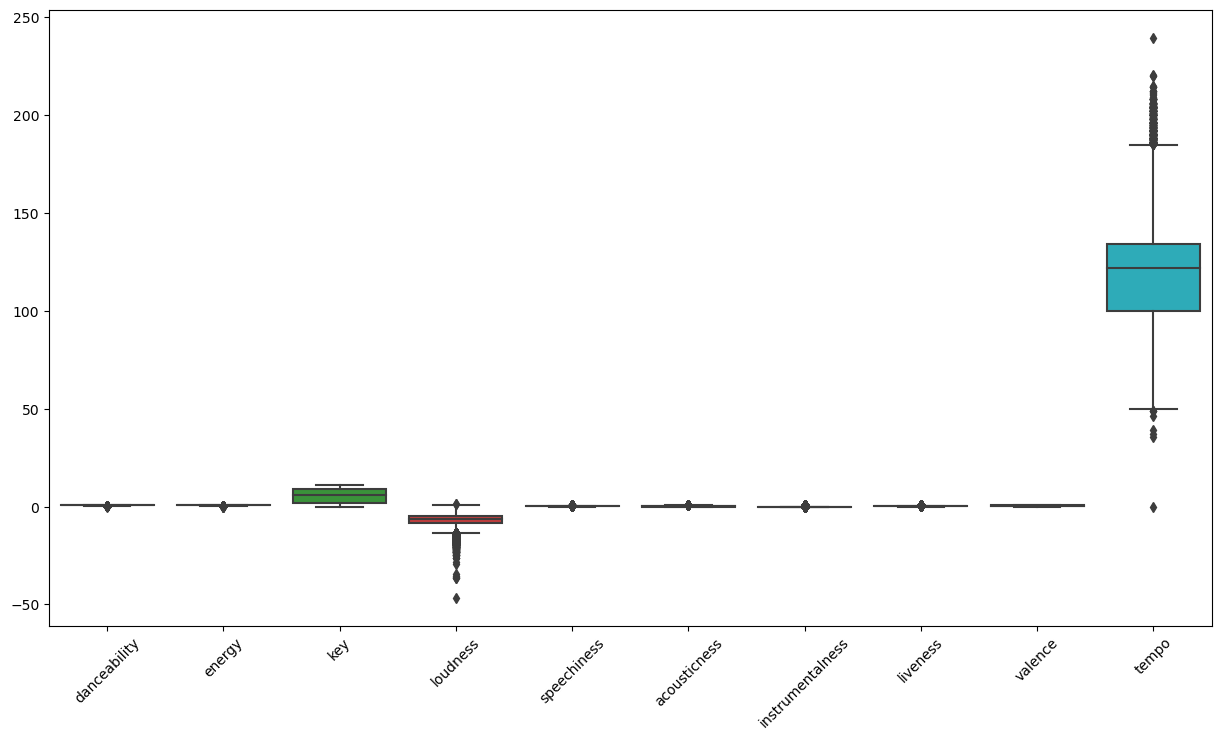

In [10]:
# scale 차이
plt.figure(figsize=(15, 8))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.show()

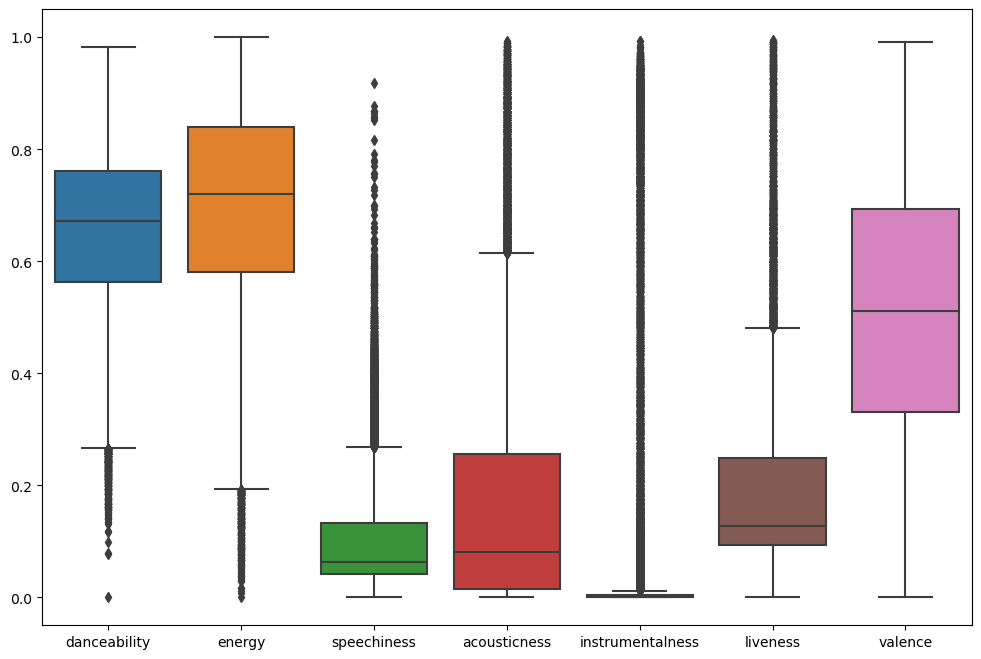

In [11]:
# key, loudness, tempo 컬럼을 제외하고 확인

plt.figure(figsize=(12, 8))
sns.boxplot(data=X.drop(['key', 'loudness', 'tempo'], axis=1))
plt.show()

- key, loudness, tempo 컬럼은 다른 컬럼과는 달리 scale 차이가 크다는 것과 이상치가 많이 포함되어 있는 것으로 확인되었습니다.

-------

#### 최적의 모델 탐색

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [21]:
# 랜덤 포레스트 적용

params = {
    'max_depth' : [10, 100, 1000],
    'n_estimators' : [10, 50, 100], # 몇 개의 나무
    'min_samples_leaf' : [8, 12],
    'min_samples_split' : [8, 12] 
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1) # n_jobs는 cpu를 몇 개 쓸 것인가? -1은 전부
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [10, 100, 1000],
                         'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [10, 50, 100]})

In [22]:
# 결과 정리를 위한 작업

cv_results_df = pd.DataFrame(grid_cv.cv_results_)

target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
17,1,0.536554,100,100
29,1,0.536554,100,1000
26,1,0.536554,100,1000
14,1,0.536554,100,100
32,5,0.534270,100,1000


In [23]:
rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(X_train, y_train)

pred = rf_clf_best.predict(X_test)
accuracy_score(y_test, pred)

0.5485836125494974

In [12]:
# 로지스틱 회귀

lr_clf = LogisticRegression(random_state=13, solver='lbfgs')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
accuracy_score(y_test, lr_pred)

c:\Users\rou59\anaconda3\envs\ds_study\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.3938470910752361

In [13]:
# 의사결정 나무

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=10)
dt_clf.fit(X_train, y_train)
dt_pred = lr_clf.predict(X_test)
accuracy_score(y_test, dt_pred)

0.3938470910752361

In [14]:
# KNN

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, knn_pred)

0.33734389278099297

In [15]:
# SVC

svm_clf = SVC(kernel='linear', random_state=13)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
accuracy_score(y_test, svm_pred)

0.4634480657934816

#### 부스팅

In [21]:
# XGBoost 

xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
accuracy_score(y_test, xgb_pred)

0.5266524520255863

In [20]:
# Light GBM

lgbm_clf = LGBMClassifier(n_estimators=100)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)
accuracy_score(y_test, lgbm_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2307
[LightGBM] [Info] Number of data points in the train set: 26262, number of used features: 10
[LightGBM] [Info] Start training from score -1.699924
[LightGBM] [Info] Start training from score -1.840447
[LightGBM] [Info] Start training from score -1.777469
[LightGBM] [Info] Start training from score -1.799327
[LightGBM] [Info] Start training from score -1.754535
[LightGBM] [Info] Start training from score -1.889861


0.546603716113311

In [19]:
# Gradient Boosting Machine(GBM)

gb_clf = GradientBoostingClassifier(random_state=13)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
accuracy_score(y_test, gb_pred)

0.5338105391410295

#### 스케일러 시도하기

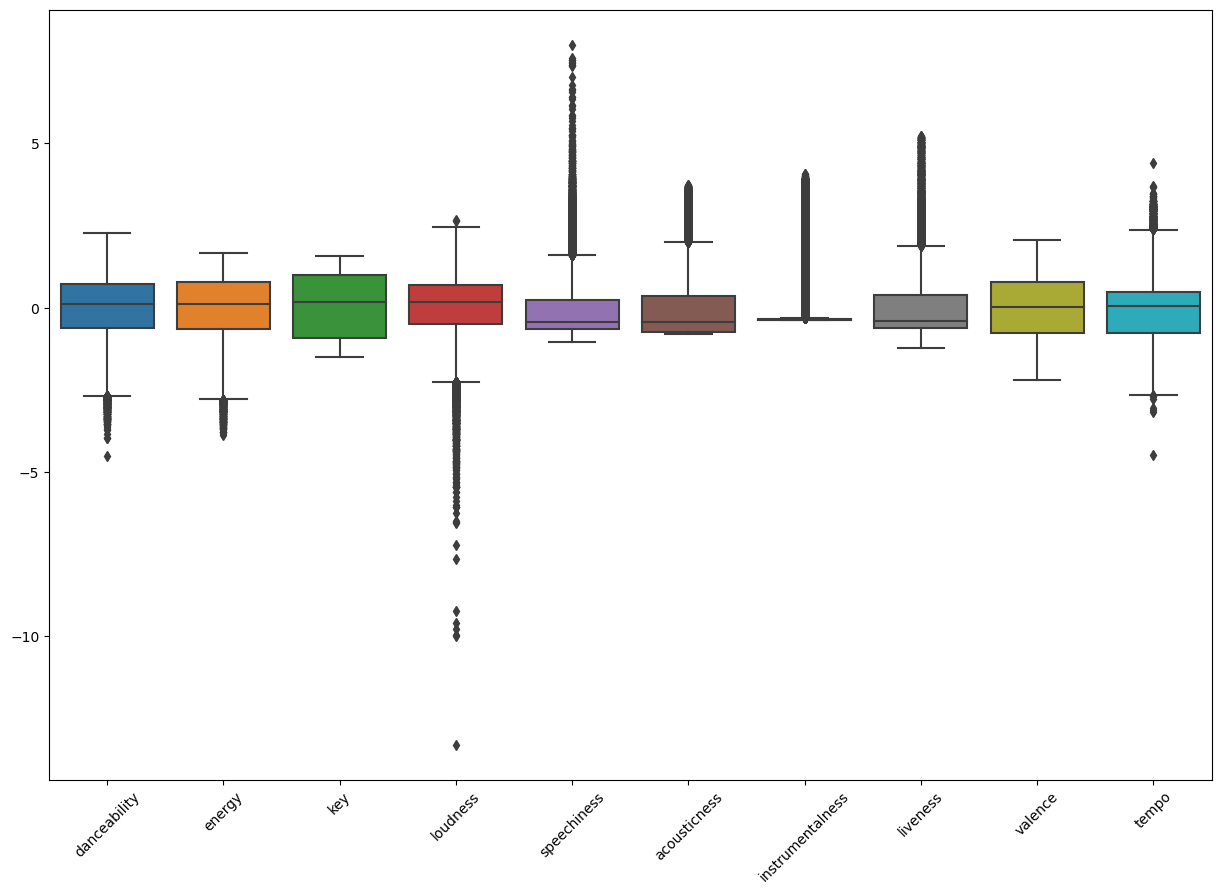

In [14]:
# StandardScaler
SS = StandardScaler()
X_ss = SS.fit_transform(X)

X_ss_pd = pd.DataFrame(X_ss, columns=X.columns)
plt.figure(figsize=(15, 10))
sns.boxplot(data=X_ss_pd)
plt.xticks(rotation=45)
plt.show();

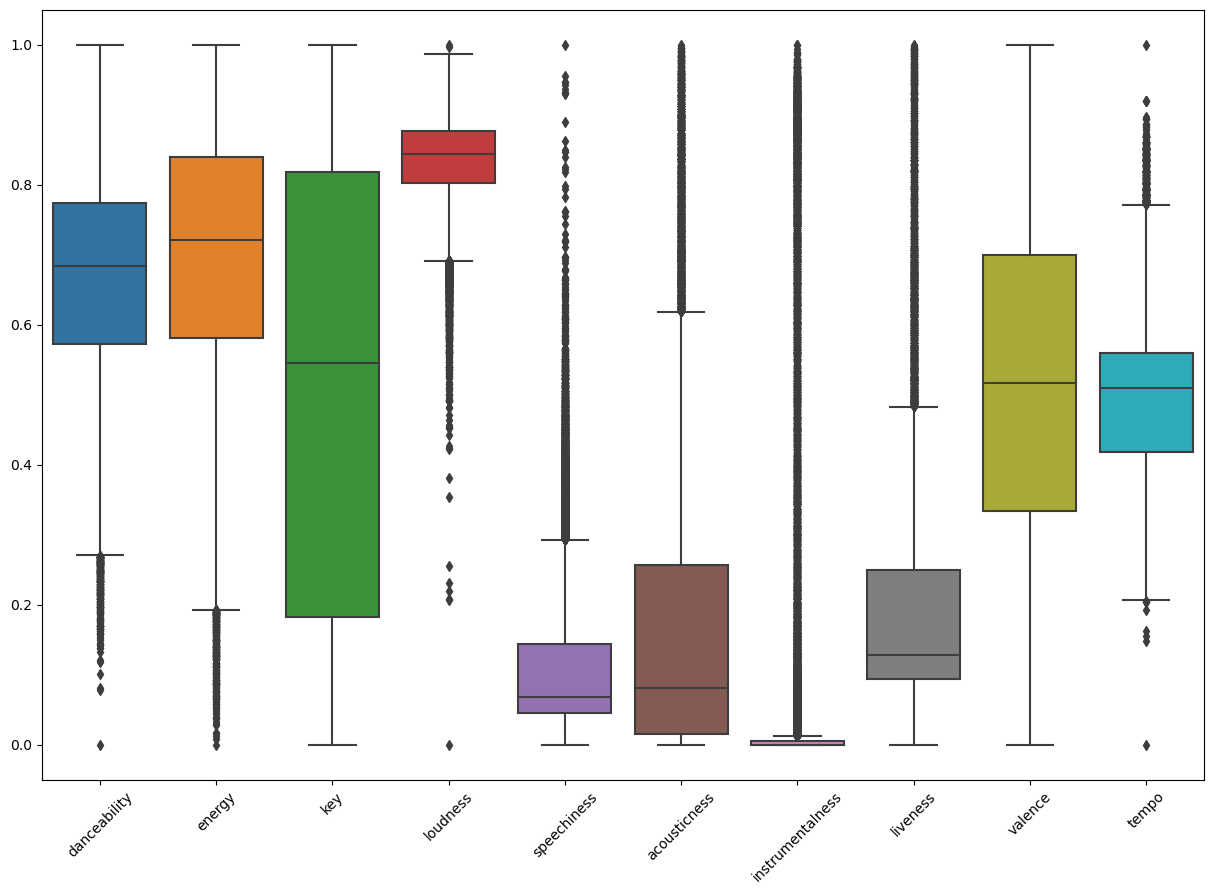

In [22]:
# MinMaxScaler
MMS = MinMaxScaler()
X_mms = MMS.fit_transform(X)

X_mms_pd = pd.DataFrame(X_mms, columns=X.columns)
plt.figure(figsize=(15, 10))
sns.boxplot(data=X_mms_pd)
plt.xticks(rotation=45)
plt.show();

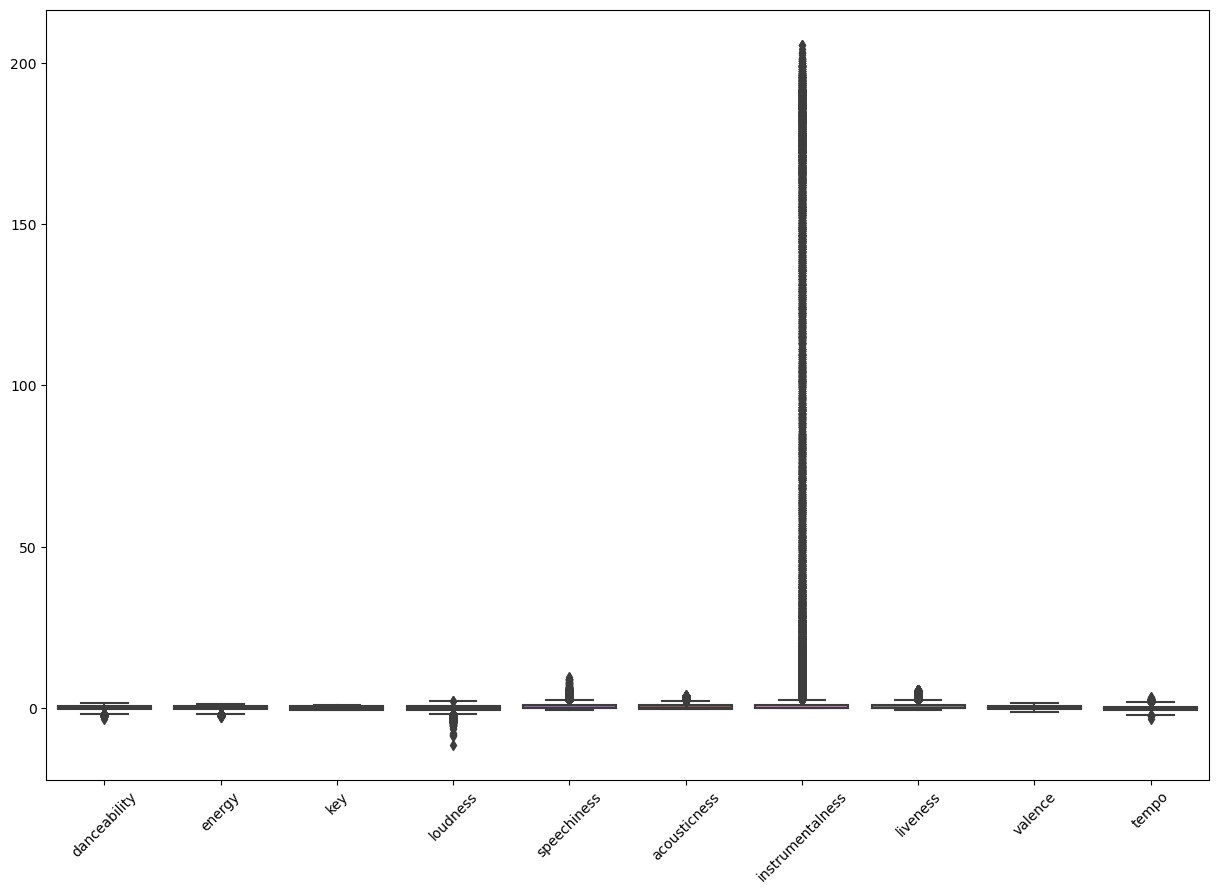

In [16]:
# RobustScaler

RS = RobustScaler()
X_rs = RS.fit_transform(X)

X_rs_pd = pd.DataFrame(X_rs, columns=X.columns)
plt.figure(figsize=(15, 10))
sns.boxplot(data=X_rs_pd)
plt.xticks(rotation=45)
plt.show();

#### 스케일러 + 부스팅

In [24]:
scalers = {
    'StandardScaler' : StandardScaler(),
    'MinMaxScaler' : MinMaxScaler(),
    'RobustScaler' : RobustScaler()
}

accuracies = {}

for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=13)

    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[scaler_name] = accuracy


for scaler_name, accuracy in accuracies.items():
    print(f'{scaler_name} → Accuracy = {accuracy : .4f}')

StandardScaler → Accuracy =  0.5448
MinMaxScaler → Accuracy =  0.5448
RobustScaler → Accuracy =  0.5448


#### MinMaxScaler 선택, 최적의 하이퍼파라미터 탐색

In [25]:

params = {
    'max_depth': [7, 10, 15],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid_cv = GridSearchCV(xgb_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_mms, y)

results = pd.DataFrame(grid_cv.cv_results_)
results = results[['param_max_depth', 'param_n_estimators', 'param_learning_rate', 'mean_test_score', 'rank_test_score']]
results = results.sort_values(by='rank_test_score')

print("GridSearchCV 결과:")
print(results)
print("\n최적의 하이퍼파라미터:", grid_cv.best_params_)

# test 데이터 예측
best_model = grid_cv.best_estimator_
y_pred = best_model.predict(X_mms)

accuracy = accuracy_score(y, y_pred)
print("최적 모델의 정확도:", accuracy)

GridSearchCV 결과:
   param_max_depth param_n_estimators param_learning_rate  mean_test_score  \
12              10                100                 0.1         0.513191   
5               10                300                0.05         0.513130   
2                7                300                0.05         0.511972   
3               10                100                0.05         0.511972   
10               7                200                 0.1         0.511728   
4               10                200                0.05         0.511393   
13              10                200                 0.1         0.510419   
21              10                100                 0.2         0.510388   
1                7                200                0.05         0.510358   
8               15                300                0.05         0.510114   
18               7                100                 0.2         0.510114   
17              15                300          

-----------------

#### 최종 모델 학습

- scaler별 정확도 비교 후 MinMaxScaler 선택

In [26]:
MMS = MinMaxScaler()
X_scaled = MMS.fit_transform(X)

In [30]:
# 알고리즘, 하이퍼파라미터 적용 - 정확도 비교 후 XGBoost 선택

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=13)
best_model = XGBClassifier(max_depth=7, n_estimators=300, learning_rate=0.05)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("최적 모델의 정확도 : {:.2f}%".format(accuracy * 100))

최적 모델의 정확도 : 55.00%


----------------

#### 장르 분류 모델로 날씨 데이터 장르 분류

In [29]:
# 날씨 데이터 불러오기

spotify_weather = pd.read_csv('./data/weather_spotify_songs.csv', sep=',', index_col=0)

# Null 값 제거

spotify_weather = spotify_weather.dropna()
spotify_weather.head(2)

,region,date,month,spotify_id,artist,track_name,position,streams,danceability,energy,...,acousticness,tempo,valence,explicit,temp,rain,snow,cloud,humidity,const
0,AUT,2019-01-02,1,7KPGeiXWDsGEvFK62wzU8E,Capital Bra,Benzema,1,35174,0.78,0.69,...,0.48,100.08,0.26,1.0,-5,1,1,48,69,1
1,AUT,2019-01-03,1,7KPGeiXWDsGEvFK62wzU8E,Capital Bra,Benzema,1,34237,0.78,0.69,...,0.48,100.08,0.26,1.0,-3,1,1,91,70,1


In [31]:
# 장르 라벨링

X_weather = spotify_weather[['danceability', 'energy', 'key', 'loudness', 'speechiness',
                        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
X_weather_scaled = MMS.transform(X_weather)
y_weather_pred = best_model.predict(X_weather_scaled)
spotify_weather['playlist_genre_num'] = y_weather_pred

#### 라벨링 된 장르 데이터 저장

In [13]:
save_genre = copy.deepcopy(spotify_weather)
save_genre['playlist_genre_num'] = label_encoder.inverse_transform(save_genre['playlist_genre_num']) 
save_genre = save_genre.drop_duplicates(subset=['region', 'date', 'track_name', 'artist'], keep='first')
save_genre = save_genre.rename(columns={
    'date': 'DATE',
    'region': 'COUNTRY_CODE', 
    'playlist_genre_num': 'GENRE',
    'streams': 'STREAMS'
})

save_genre=save_genre[['DATE', 'COUNTRY_CODE', 'GENRE', 'STREAMS']]
save_genre.to_csv('./data/cleaned/GENRE_STREAMS_BY_COUNTRY.csv', index=False)

#### 30000 데이터와 예측한 날씨 데이터의 음악 id를 이용해 정답확인
- 날씨 데이터의 중복된 음악을 확인한 결과, 각 음악마다 300일의 날씨 데이터가 수집된 것을 확인했습니다. <br> 이 중복된 음악을 기반으로 라벨링된 장르가 정확한지 확인하고자 합니다.

In [32]:
# 중복되는 음악을 삭제하는 기준으로 음악별 streams수가 가장 큰 데이터만 남기고 삭제
spotify_weather = spotify_weather.groupby('spotify_id').apply(lambda x: x.loc[x['streams'].idxmax()]).reset_index(drop=True)

In [33]:
spotify_30000.rename(columns={'playlist_genre_num':'genre'}, inplace=True)
spotify_merge = pd.merge(spotify_weather, spotify_30000[['track_id', 'genre']], left_on='spotify_id', right_on='track_id', 
                         how='left')[['spotify_id', 'playlist_genre_num', 'genre']]

In [16]:
matching = spotify_merge[spotify_merge['genre'] == spotify_merge['playlist_genre_num']]
print(f'정답 확인 : {1921}개 중 {len(matching)}개')

정답 확인 : 1921개 중 1848개


------------------

#### 장르 분류 모델 결과

- 30000 데이터와 날씨 데이터의 중복되는 음악을 통해 모델의 정답률을 확인했다. 첫 시도에서는 약 1200의 정답을 맞췄다.  <br>  모델의 성능을 향상시키기 위해 다양한 알고리즘, 스케일러 및 하이퍼파라미터를 실험한 후, 최적 모델을 통한 라벨링 후 결과를 확인했습니다. <br> 그 결과 1848개의 장르를 정확하게 분류하는 것을 확인할 수 있었습니다.

------------------------

#### 장르 라벨링한 날씨 데이터 탐색

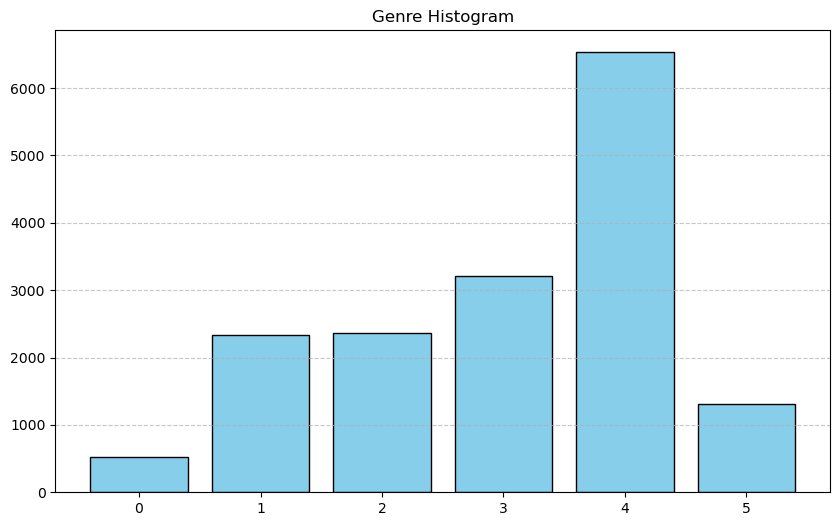

playlist_genre_num
4    6531
3    3217
2    2364
1    2336
5    1314
0     523
Name: count, dtype: int64


In [36]:
# 장르별 분포 확인
genre_counts = spotify_weather['playlist_genre_num'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='skyblue', edgecolor='black')
plt.title('Genre Histogram')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(genre_counts)

- 날씨별 장르 히스토그램 확인

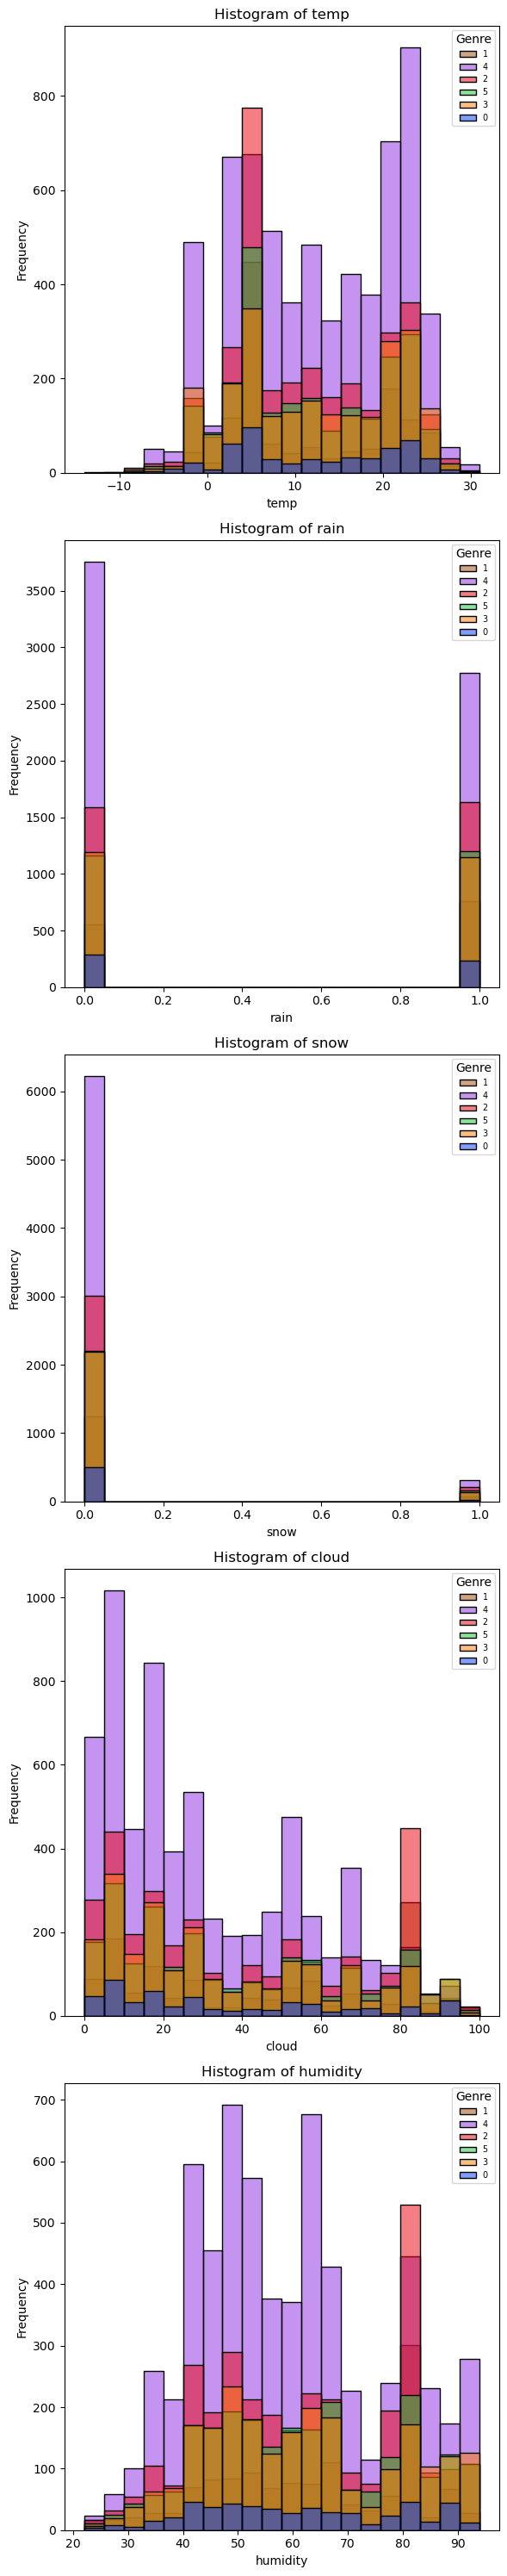

In [35]:

features = ['temp', 'rain', 'snow', 'cloud', 'humidity']

# 그래프의 크기 설정
plt.figure(figsize=(6, 30))

# 각 특성에 대한 히스토그램 그리기
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i + 1)
    sns.histplot(data=spotify_weather, x=feature, hue='playlist_genre_num', multiple='layer', bins=20, alpha=0.5, palette='bright')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Genre', labels=spotify_weather['playlist_genre_num'].unique(), fontsize='x-small')
    
plt.tight_layout()
plt.show()

```
숫자별 의미하는 장르
0: edm, 1: latin, 2: pop, 3: r&b, 4: rap, 5: rock
```

- rap 장르가 타 장르보다 2배 이상 많은 것으로 확인되었다.
- 히스토그램을 확인하니 모든 장르에서 rap 장르가 큰 분포를 나타내는 것을 확인했다.
-  추후 날씨별 장르 추천에 문제가 생기는 것을 방지하기 위한 오버샘플링 진행

In [ ]:
# 데이터 오버샘플링 

def oversample_data(df):
    oversampled_data = []
    
    for _, group in df.groupby('playlist_genre_num'):
        max_samples = df['playlist_genre_num'].value_counts().max()
        current_samples = group.shape[0]
        
        if current_samples < max_samples:
            oversampled_group = resample(group, replace=True, n_samples=max_samples - current_samples, random_state=42)
            oversampled_data.append(oversampled_group)
    
    oversampled_df = pd.concat([df] + oversampled_data, ignore_index=True)
    return oversampled_df

song_weather_df = oversample_data(spotify_weather)

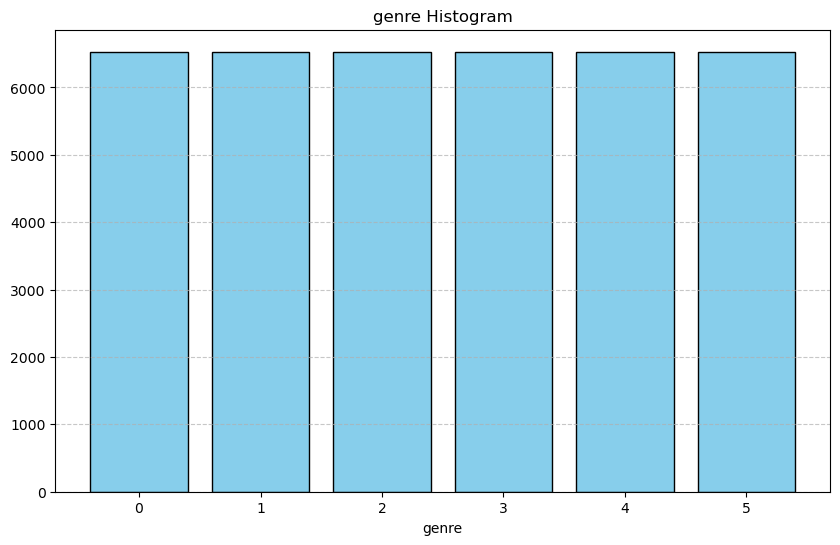

playlist_genre_num
1    6531
4    6531
2    6531
5    6531
3    6531
0    6531
Name: count, dtype: int64


In [40]:
# 다시 장르별 분포 확인
genre_counts = song_weather_df['playlist_genre_num'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='skyblue', edgecolor='black')
plt.title('genre Histogram')
plt.xlabel('genre')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(genre_counts)

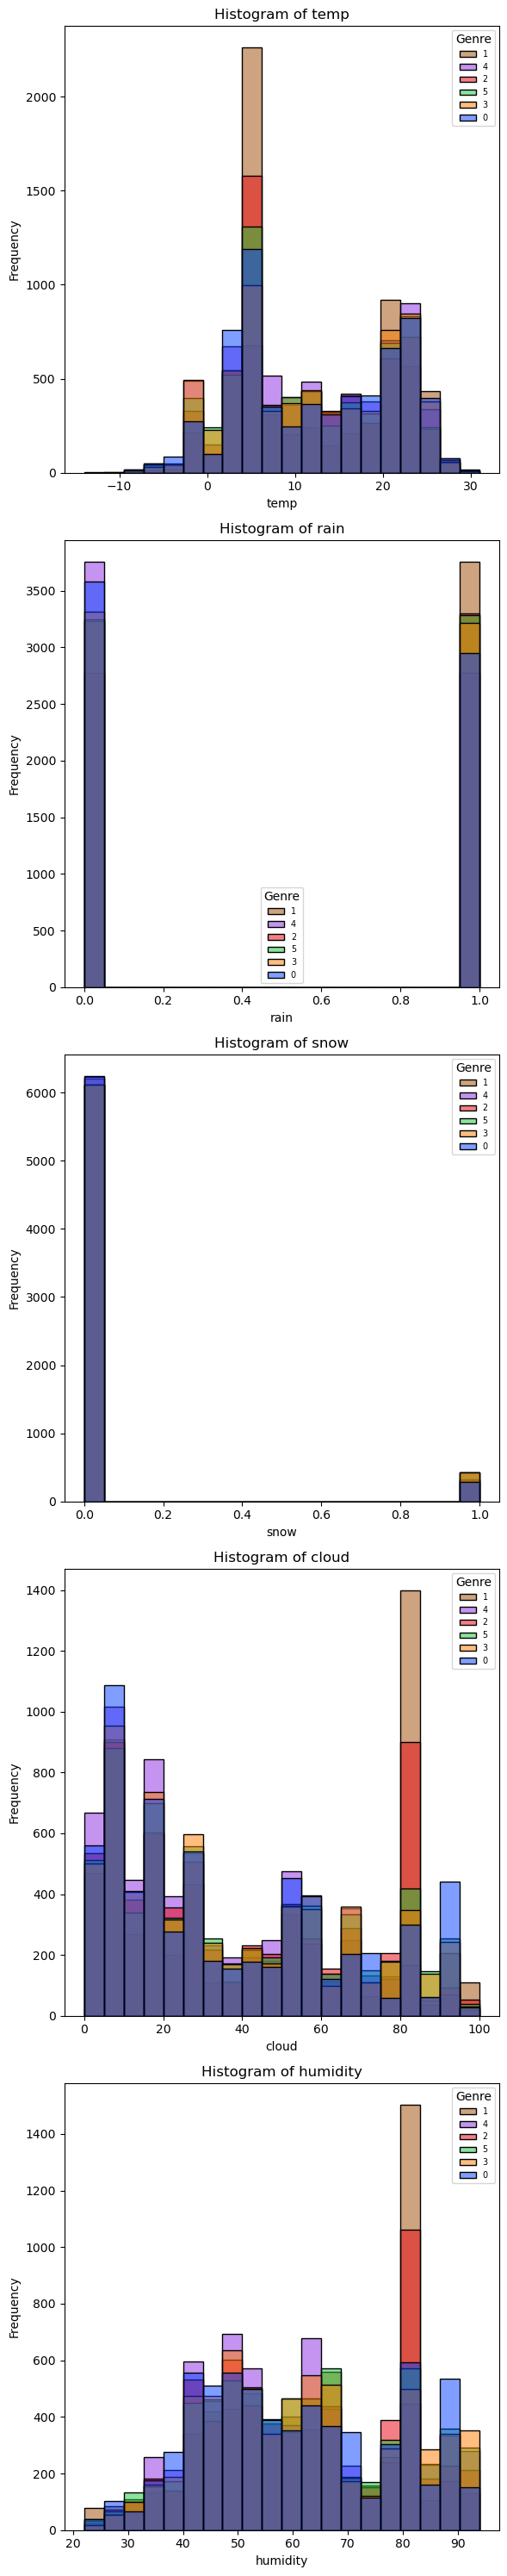

In [41]:
features = ['temp', 'rain', 'snow', 'cloud', 'humidity']

# 그래프의 크기 설정
plt.figure(figsize=(6, 30))

# 각 특성에 대한 히스토그램 그리기
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i + 1)
    sns.histplot(data=song_weather_df, x=feature, hue='playlist_genre_num', multiple='layer', bins=20, alpha=0.5, palette='bright')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Genre', labels=song_weather_df['playlist_genre_num'].unique(), fontsize='x-small')
    
plt.tight_layout()
plt.show()

- 오버샘플링 이전에는 모든 히스토그램에서 rap 장르만 큰 분포를 보였지만, 진행한 후에는 해당 문제가 해결된 것을 확인할 수 있었습니다.

-------------------